In [1]:
import pandas as pd
import numpy as np
import nltk
import pandas as pd
import re
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load data
df = pd.read_excel("Data.xlsx")
Y = df['Orientation']
X = df['TI'] + ' ' + df['AB']

In [3]:
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [4]:
print(np.shape(X_train))
print(np.shape(X_val))
print(np.shape(X_test))

(835,)
(179,)
(179,)


In [5]:
from keras.preprocessing.text import Tokenizer
## Tokenize the sentences
tokenizer = Tokenizer(num_words=8000 )
tokenizer.fit_on_texts(list(X_train)+list(X_test)+list(X_val))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val = tokenizer.texts_to_sequences(X_val)

In [6]:
vocab_size = len(tokenizer.word_index) + 1 

In [7]:
print(X[100])
print(X_train[100])

Disability, anxiety and depression in patients with medication-overuse headache in primary care - the BIMOH study Background and purpose: Medication-overuse headache (MOH) is common in the general population. Detoxification is the general treatment principle for MOH. The present paper is based on a study of a brief intervention (BI) for MOH in primary care. New data 
[292, 2148, 353, 2, 673, 3, 2626, 631, 3, 35, 231, 4, 98, 9, 790, 204, 3, 25, 3415, 292, 353, 2, 673, 3, 5077, 631, 1048, 3, 1, 865, 119, 2, 375, 735, 3, 579, 231, 7, 134, 8, 1003, 1526, 151, 3, 8, 438, 5078, 1041, 5079, 8, 785]


In [8]:
X_train = tf.keras.utils.pad_sequences(X_train, padding='post', maxlen=100)
X_test = tf.keras.utils.pad_sequences(X_test, padding='post', maxlen=100)
X_val = tf.keras.utils.pad_sequences(X_val, padding='post', maxlen=100)

In [9]:
print(X_train[100])

[ 292 2148  353    2  673    3 2626  631    3   35  231    4   98    9
  790  204    3   25 3415  292  353    2  673    3 5077  631 1048    3
    1  865  119    2  375  735    3  579  231    7  134    8 1003 1526
  151    3    8  438 5078 1041 5079    8  785    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train.values)
y_test = le.transform(y_test.values)
y_val = le.transform(y_val.values)

In [11]:
embedding_dim = 50

In [12]:
model_basic = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=100),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu'),  
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),    
    tf.keras.layers.Dropout(0.5),    
    tf.keras.layers.Dense(3, activation='softmax')
    ])

In [13]:
model_basic.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           429000    
                                                                 
 conv1d (Conv1D)             (None, 96, 32)            8032      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                        

In [14]:
model_basic.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.optimizers.Adam(), metrics = ['acc'])

In [15]:
checkpoint_filepath = "C:/Users/Thomas/Desktop/CSS3/model"

In [16]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

In [78]:
history = model_basic.fit(
    x=X_train,
    y=y_train,
    epochs=50,
    validation_data=(X_val,y_val),
    shuffle=True,
    batch_size = 10,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
84/84 [==============================] - 2s 10ms/step - loss: 1.0859 - acc: 0.4240 - val_loss: 1.0803 - val_acc: 0.4190
Epoch 2/50
84/84 [==============================] - 1s 9ms/step - loss: 1.0367 - acc: 0.4419 - val_loss: 1.0721 - val_acc: 0.4358
Epoch 3/50
84/84 [==============================] - 1s 8ms/step - loss: 0.9022 - acc: 0.6228 - val_loss: 1.0400 - val_acc: 0.4469
Epoch 4/50
84/84 [==============================] - 1s 8ms/step - loss: 0.4890 - acc: 0.9305 - val_loss: 0.9683 - val_acc: 0.5587
Epoch 5/50
84/84 [==============================] - 1s 6ms/step - loss: 0.1542 - acc: 0.9940 - val_loss: 0.9702 - val_acc: 0.5307
Epoch 6/50
84/84 [==============================] - 1s 8ms/step - loss: 0.0534 - acc: 0.9988 - val_loss: 0.9909 - val_acc: 0.5642
Epoch 7/50
84/84 [==============================] - 1s 10ms/step - loss: 0.0336 - acc: 0.9976 - val_loss: 1.0091 - val_acc: 0.5754
Epoch 8/50
84/84 [==============================] - 0s 5ms/step - loss: 0.0186 - acc: 0.

In [17]:
model_basic.load_weights('C:/Users/Thomas/Desktop/CSS3/model')

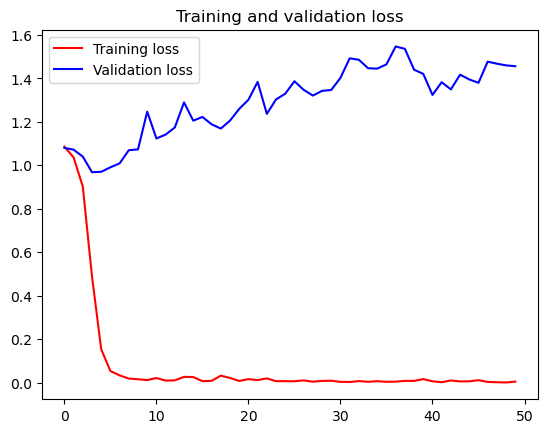

In [80]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

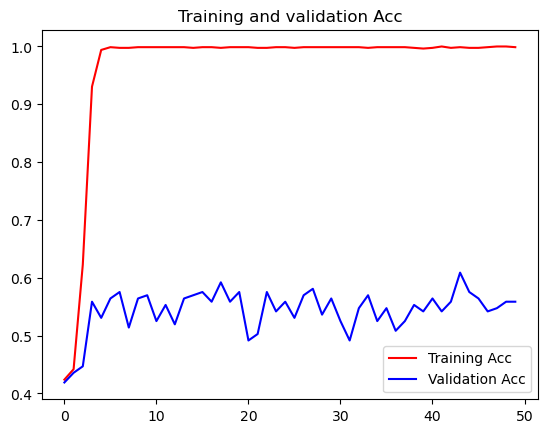

In [81]:
accu = history.history['acc']
val_accu = history.history['val_acc']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, accu, 'r', label='Training Acc')
plt.plot(epochs, val_accu, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.legend()

In [18]:
y_train_pred = tf.keras.backend.argmax(
    model_basic.predict(X_train),
    axis=-1
)
accuracy_test = accuracy_score(y_train, y_train_pred)
print("Train accuracy for the CNN model combined Title and Abstract:", accuracy_test)

27/27 [==============================] - 1s 5ms/step
Train accuracy for the CNN model combined Title and Abstract: 0.9988023952095808


In [19]:
y_val_pred = tf.keras.backend.argmax(
    model_basic.predict(X_val),
    axis=-1
)
accuracy_test = accuracy_score(y_val, y_val_pred)
print("Validation accuracy for the CNN model combined Title and Abstract:", accuracy_test)

6/6 [==============================] - 0s 23ms/step
Validation accuracy for the CNN model combined Title and Abstract: 0.6089385474860335


In [20]:
y_test_pred = tf.keras.backend.argmax(
    model_basic.predict(X_test),
    axis=-1
)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Test accuracy for the CNN model combined Title and Abstract:", accuracy_test)

6/6 [==============================] - 0s 2ms/step
Test accuracy for the CNN model combined Title and Abstract: 0.5418994413407822


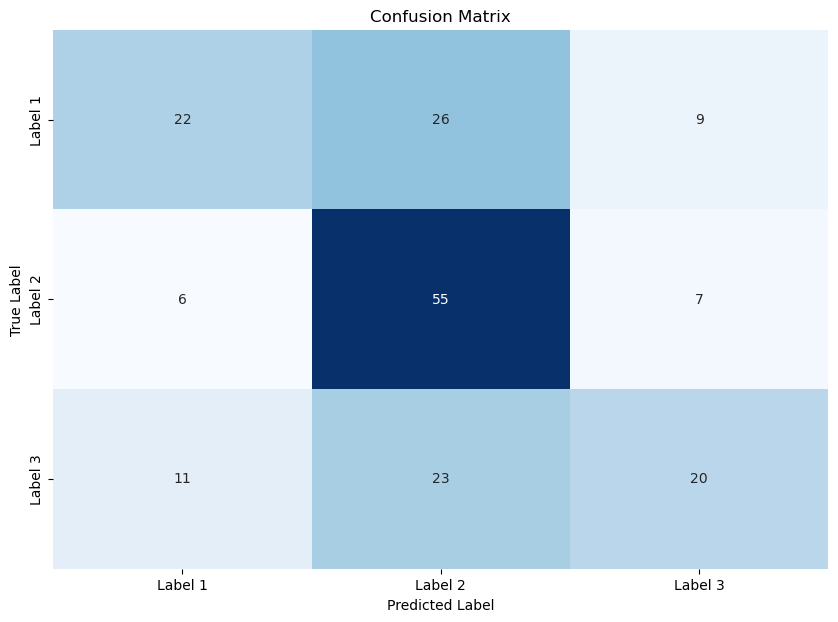

In [83]:
# Compute confusion matrix
conf_mat = confusion_matrix(y_test, y_test_pred)

# Create confusion matrix plot using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Label 1', 'Label 2', 'Label 3'], yticklabels=['Label 1', 'Label 2', 'Label 3'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()